In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## init stereo aruco detector scene builder

In [2]:
from pkg.detector.aruco.marker_config import *
from pkg.detector.aruco.stereo import ArucoStereo
from pkg.detector.camera.realsense import RealSense
from pkg.detector.camera.kinect import Kinect
from pkg.geometry.builder.scene_builder import SceneBuilder

s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

In [3]:
from pkg.planning.filtering.reach_filter import ReachTrainer
from pkg.controller.combined_robot import *

In [4]:
rtrain = ReachTrainer(scene_builder=s_builder)

In [5]:
def fn_rpy(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    r,p,y = Rot2rpy(R)
    return (radius, theta, height, r,p,y, radius**2, ee_dist, ee_dist**2)

def fn_quat(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    x,y,z,w = Rotation.from_dcm(R).as_quat()
    return (radius, theta, height, x,y,z,w, radius**2, ee_dist, ee_dist**2)

def fn_rmat(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    r11, r12, r13, r21, r22, r23, r31, r32, r33 = R.flatten()
    return (radius, theta, height, r11, r12, r13, r21, r22, r23, r31, r32, r33, radius**2, ee_dist, ee_dist**2)

def fn_zxvec(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    z1, z2, z3 = R[:,2]
    x1, x2, x3 = R[:,0]
    return (radius, theta, height, z1, z2, z3, x1, x2, x3, radius**2, ee_dist, ee_dist**2)

def fn_pure(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    return (radius, theta, height, azimuth_loc, zenith, ee_dist, rot_z)

def fn_re_sq(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    return (radius, theta, height, azimuth_loc, zenith, radius**2, ee_dist, ee_dist**2, rot_z)

fn_list = [fn_rpy, fn_quat, fn_rmat, fn_zxvec, fn_pure, fn_re_sq]


function all sane


## Load previous result or initialize dict

In [33]:
try: 
    resdat = load_pickle(os.path.join(SAVE_DIR, "{}.pkl".format(rtrain.robot_type.name)))
    test_panda_set_dict = resdat["test_panda_set_dict"]
    fn_names = resdat["fn_names"]
    C_svm_list = resdat["C_svm_list"]
except:
    test_panda_set_dict = {}

In [ ]:
samplevec_list_test, success_list_test = rtrain.load_data(RobotType.panda, "test")
for fn in fn_list:
    fn(*samplevec_list_test[0])
    print("function ok: {}".format(fn.__name__))
print("function all sane")

C_svm_list = [1000, 2000, 4000, 8000]

In [6]:
for fn in fn_list:
    if fn.__name__ in test_panda_set_dict:
        test_panda_set = test_panda_set_dict[fn.__name__]
    else:
        test_panda_set = {}
    for C_svm in C_svm_list:
        test_panda = rtrain.load_and_learn(RobotType.panda, C_svm=C_svm, feature_fn=fn)
        test_panda_set[str(C_svm)] = test_panda
    test_panda_set_dict[fn.__name__] = test_panda_set

connection command:
panda0: False
trainset: 	1668.5 ms/1 = 1668.5 ms (1668.463/1668.463)
testset: 	415.9 ms/1 = 415.9 ms (415.863/415.863)

trainning accuracy = 95.0 %
test accuracy = 92.98 %
trainning success accuracy = 97.45 %
trainning failure accuracy = 91.33 %
test success accuracy = 95.33 %
test failure accuracy = 89.2 %
connection command:
panda0: False
trainset: 	1576.9 ms/1 = 1576.9 ms (1576.914/1576.914)
testset: 	394.2 ms/1 = 394.2 ms (394.151/394.151)

trainning accuracy = 95.29 %
test accuracy = 93.06 %
trainning success accuracy = 97.63 %
trainning failure accuracy = 91.77 %
test success accuracy = 95.27 %
test failure accuracy = 89.51 %
connection command:
panda0: False
trainset: 	1512.8 ms/1 = 1512.8 ms (1512.785/1512.785)
testset: 	377.1 ms/1 = 377.1 ms (377.087/377.087)

trainning accuracy = 95.64 %
test accuracy = 92.58 %
trainning success accuracy = 97.75 %
trainning failure accuracy = 92.45 %
test success accuracy = 94.65 %
test failure accuracy = 89.25 %
connectio

trainset: 	1441.9 ms/1 = 1441.9 ms (1441.914/1441.914)
testset: 	360.0 ms/1 = 360.0 ms (360.005/360.005)

trainning accuracy = 97.08 %
test accuracy = 93.92 %
trainning success accuracy = 98.52 %
trainning failure accuracy = 94.9 %
test success accuracy = 95.23 %
test failure accuracy = 91.81 %
connection command:
panda0: False
trainset: 	1364.5 ms/1 = 1364.5 ms (1364.541/1364.541)
testset: 	342.4 ms/1 = 342.4 ms (342.397/342.397)

trainning accuracy = 97.58 %
test accuracy = 93.54 %
trainning success accuracy = 98.85 %
trainning failure accuracy = 95.68 %
test success accuracy = 94.78 %
test failure accuracy = 91.54 %
connection command:
panda0: False
trainset: 	1303.6 ms/1 = 1303.6 ms (1303.638/1303.638)
testset: 	326.7 ms/1 = 326.7 ms (326.737/326.737)

trainning accuracy = 98.17 %
test accuracy = 93.54 %
trainning success accuracy = 99.17 %
trainning failure accuracy = 96.68 %
test success accuracy = 94.55 %
test failure accuracy = 91.91 %
connection command:
panda0: False
trainset

fn:       fn_rpy   fn_quat   fn_rmat  fn_zxvec   fn_pure  fn_re_sq
vals:      93.06     93.98      93.2     93.92      93.6      93.9
max: 93.98 - [1]


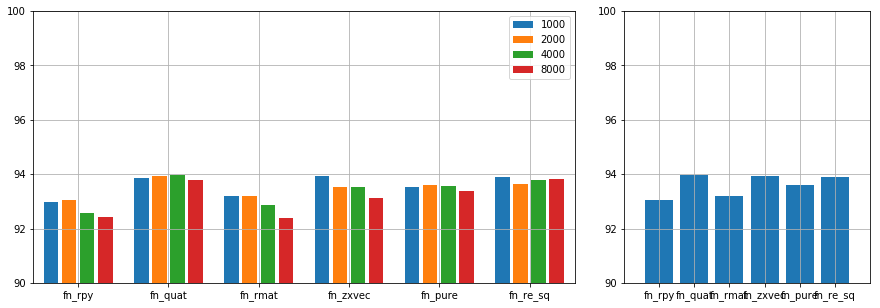

In [23]:
from pkg.utils.plot_utils import *
fn_names = map(lambda x:x.__name__, fn_list)
fn_maxvals = [max(test_panda_set_dict[fname].values()) for fname in fn_names]
plt.figure(figsize=(15,5))
plt.subplot(1,3,(1,2))
grouped_bar(test_panda_set_dict, groups=fn_names, options=map(str,C_svm_list))
plt.axis([0, len(fn_names)*(len(C_svm_list)+1), 90, 100])
plt.subplot(1,3,3)
plt.bar(fn_names, fn_maxvals)
plt.axis([-1, len(fn_names), 90, 100])
plt.grid()
maxval = np.max(fn_maxvals)
idc_max = np.where(np.array(fn_maxvals)==maxval)[0]
print("fn:   "+"".join(["{:>10}".format(fname) for fname in fn_names]))
print("vals: "+"".join(["{:10}".format(val) for val in fn_maxvals]))
print("max: {} - {}".format(maxval, idc_max))

## Save result

In [31]:
# SAVE_DIR = os.path.join(os.environ["RNB_PLANNING_DIR"], "data", "reach_svm_ft_analysis")
# try_mkdir(SAVE_DIR)
# save_pickle(os.path.join(SAVE_DIR, "{}.pkl".format(rtrain.robot_type.name)),
#             {"test_panda_set_dict":test_panda_set_dict, "fn_names":fn_names, "C_svm_list":C_svm_list})

## load and test

In [ ]:
rtrain.load_and_test(RobotType.indy7gripper)

In [ ]:
rtrain.load_and_test(RobotType.panda)

## Update label

In [ ]:
from pkg.planning.filtering.reach_filter import *

In [ ]:
ROBOT_TYPE = RobotType.indy7
TIP_LINK = "indy0_tcp"
TIMEOUT = 0.3
DATA_DIVS = ["train", "test"]
UPDATE_LABELS = [True] # to reduce feasible ones, as joint limit is reduced

In [ ]:
time_lists = []
for DATA_DIV in DATA_DIVS:
    rtrain.update_label(robot_type=ROBOT_TYPE, tip_link=TIP_LINK, data_div=DATA_DIV, update_labels=UPDATE_LABELS, timeout=TIMEOUT)
    time_lists.append(deepcopy(rtrain.time_list))
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(sorted(time_lists[0]), '.')
plt.subplot(1,2,2)
plt.plot(sorted(time_lists[0]), '.')

## Load and visualize

In [ ]:
ROBOT_TYPE = RobotType.panda
TIP_LINK = "panda0_hand"
TIMEOUT = 0.5
DATA_DIV = "test"

In [ ]:
rtrain.load_and_visualize(robot_type=ROBOT_TYPE, tip_link=TIP_LINK, data_div=DATA_DIV, timeout=TIMEOUT)